In [1]:
import os 
import numpy as np
import torch 
import matplotlib.pyplot as plt

Linear Mic Array(8cm)
-   mics(2, 4, 8)
-   Loss (RI, RI_MAG, RI_MAG_PD, RI_PD, RI_PD_REF)

In [2]:
reverb_log_dir = '../Logs/8cm_array_8mic/reverb/'
noisy_log_dir = '../Logs/8cm_array_8mic/noisy/point_source'
noisy_reverb_ps_log_dir = '../Logs/8cm_array_8mic/noisy_reverb/point_source'
noisy_reverb_diffuse_log_dir = '../Logs/8cm_array_8mic/noisy_reverb/diffuse'

Localization Performance Comparison Measure
- Frame Level Accuracy
- MAE (Only Correct), MAE (Only InCorrect), MAE (Overall)
- Utterance Level Accuracy

In [3]:
Loss = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
num_mics_list = [2,4,8]
doa_measures = ["frm_Acc", "utt_Acc", 'mae_only', 'mae_inc', 'mae_ove', "mic_fr"]

In [4]:
search_doa_pattern_list = []
for loss in Loss:
    for num_mics in num_mics_list:
        for measure in doa_measures:
            if measure != "mic_fr":
                doa_info_pattern = f'{loss}_est_{num_mics}mic_enh_{measure}' #inside file pattern
                search_doa_pattern_list.append(doa_info_pattern)
            else:
                #same enahacement, picking subarrays
                if num_mics==4:
                    doa_info_pattern = f'{loss}_est_{num_mics}mic_enh_{2}{measure}' #inside file pattern
                    search_doa_pattern_list.append(doa_info_pattern)
                elif num_mics==8:
                    doa_info_pattern = f'{loss}_est_{num_mics}mic_enh_{2}{measure}' #inside file pattern
                    search_doa_pattern_list.append(doa_info_pattern)
                    doa_info_pattern = f'{loss}_est_{num_mics}mic_enh_{4}{measure}' #inside file pattern
                    search_doa_pattern_list.append(doa_info_pattern)


In [5]:
search_doa_pattern_list.append("mix_8mic_frm_Acc_epoch")
search_doa_pattern_list.append("mix_2mic_frm_Acc_epoch")

In [6]:
def get_test_config_details(line):
    snr,t60,app_str = None, None,""
    
    if "dataset_condition:" in line:
        line_split_info = line.split(',')
        if line_split_info[-1]=='':
            line_split_info.pop()
        dataset_condition = line_split_info[-1].split()[-1]
        if dataset_condition=="noisy":
            snr = line_split_info[-3].split()[-1]
            app_str = f'snr_{snr}'
        elif dataset_condition=="noisy_reverb":
            snr = line_split_info[-3].split()[-1]
            t60 = line_split_info[-4].split()[-1]
            app_str = f'snr_{snr}_t60_{t60}'
        elif dataset_condition=="reverb":
            t60 = line_split_info[-4].split()[-1]
            app_str = f't60_{t60}'

            
    return snr, t60, app_str

In [7]:
#search_pattern_file
def search_pattern_file(file_path, search_pattern_list):
    exp_dict = {}
    app_str = ""
    mic_2_idx, mic_4_idx, mic_8_idx = 0, 0, 0
    mic_2_idx_ref, mic_4_idx_ref, mic_8_idx_ref = 0, 0, 0
    with open(file_path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            if app_str=="":
                snr, t60, app_str = get_test_config_details(line)
                

            for search_pattern in search_pattern_list: #search_doa_pattern_list:
                if search_pattern in line:
                    line_split_info = line.split()
                    #print(line_split_info, len(line_split_info))
                    if len(line_split_info)==5:
                        key_str = f'{search_pattern}_{app_str}'

                        if  "PESQ_NB_MIMO_RI_MAG_PD" in search_pattern and key_str not in exp_dict:
                            if 'est_2mic' in key_str:        
                                mic_idx = mic_2_idx
                                mic_2_idx +=1
                            elif 'est_4mic' in key_str:                               
                                mic_idx = mic_4_idx
                                mic_4_idx +=1
                            if 'est_8mic' in key_str: 
                                mic_idx = mic_8_idx 
                                mic_8_idx +=1
                            key_str = f'{search_pattern}_{mic_idx}_{app_str}'

                        elif "PESQ_NB_MIMO_RI_PD_REF" in search_pattern and key_str not in exp_dict:
                            if 'est_2mic' in key_str:        
                                mic_idx = mic_2_idx_ref
                                mic_2_idx_ref +=1
                            elif 'est_4mic' in key_str:                               
                                mic_idx = mic_4_idx_ref
                                mic_4_idx_ref +=1
                            if 'est_8mic' in key_str: 
                                mic_idx = mic_8_idx_ref
                                mic_8_idx_ref +=1
                            key_str = f'{search_pattern}_{mic_idx}_{app_str}'

                        exp_dict[key_str] = float(line_split_info[3])
                        #print(key_str, line.split()[3])
                
    return exp_dict
        


In [8]:

#exp_dict = search_pattern_file(os.path.join(noisy_log_dir, 'Test_functions_comparison_16467345_3.out'))

In [9]:
#exp_dict['MIMO_RI_MAG_PD_est_2mic_enh_utt_Acc_snr_0.0']

In [8]:
noisy_files = os.listdir(noisy_log_dir)

noisy_exp_dict={}
for _file in noisy_files:
    file_path = os.path.join(noisy_log_dir, _file)
    exp_dict = search_pattern_file(file_path, search_doa_pattern_list)
    noisy_exp_dict.update(exp_dict)



In [9]:
noisy_exp_dict.keys()

dict_keys(['MIMO_RI_MAG_PD_est_2mic_enh_frm_Acc_snr_0.0', 'MIMO_RI_MAG_PD_est_2mic_enh_mae_ove_snr_0.0', 'MIMO_RI_MAG_PD_est_2mic_enh_utt_Acc_snr_0.0', 'MIMO_RI_MAG_PD_est_4mic_enh_2mic_fr_snr_0.0', 'MIMO_RI_MAG_PD_est_4mic_enh_frm_Acc_snr_0.0', 'MIMO_RI_MAG_PD_est_4mic_enh_mae_ove_snr_0.0', 'MIMO_RI_MAG_PD_est_4mic_enh_utt_Acc_snr_0.0', 'MIMO_RI_MAG_PD_est_8mic_enh_2mic_fr_snr_0.0', 'MIMO_RI_MAG_PD_est_8mic_enh_4mic_fr_snr_0.0', 'MIMO_RI_MAG_PD_est_8mic_enh_frm_Acc_snr_0.0', 'MIMO_RI_MAG_PD_est_8mic_enh_mae_ove_snr_0.0', 'MIMO_RI_MAG_PD_est_8mic_enh_utt_Acc_snr_0.0', 'MIMO_RI_MAG_est_2mic_enh_frm_Acc_snr_0.0', 'MIMO_RI_MAG_est_2mic_enh_mae_ove_snr_0.0', 'MIMO_RI_MAG_est_2mic_enh_utt_Acc_snr_0.0', 'MIMO_RI_MAG_est_4mic_enh_2mic_fr_snr_0.0', 'MIMO_RI_MAG_est_4mic_enh_frm_Acc_snr_0.0', 'MIMO_RI_MAG_est_4mic_enh_mae_ove_snr_0.0', 'MIMO_RI_MAG_est_4mic_enh_utt_Acc_snr_0.0', 'MIMO_RI_MAG_est_8mic_enh_2mic_fr_snr_0.0', 'MIMO_RI_MAG_est_8mic_enh_4mic_fr_snr_0.0', 'MIMO_RI_MAG_est_8mic_enh_frm

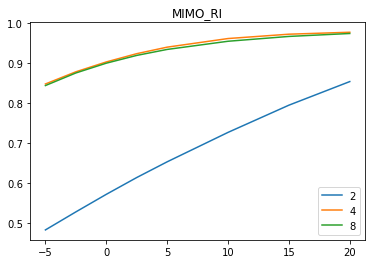

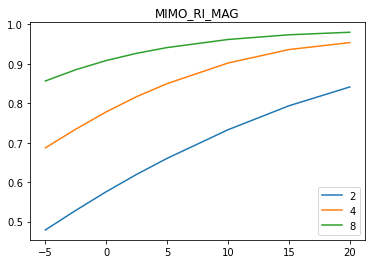

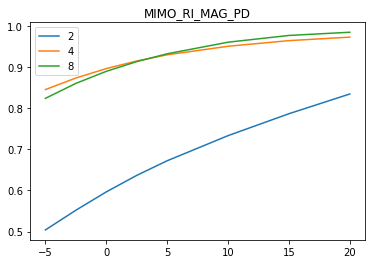

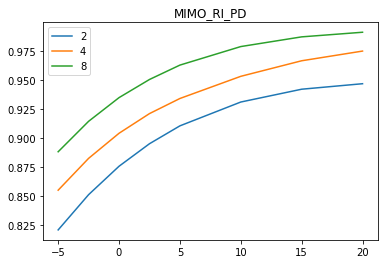

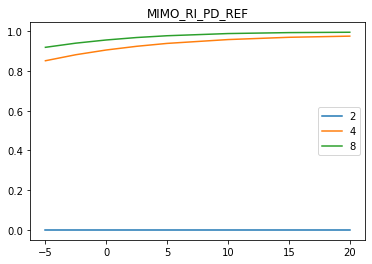

In [11]:
#plot (same loss function mic variation)
snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
measure = "frm_Acc"

keys_list = noisy_exp_dict.keys()
for loss in Loss:
    plt.figure()  
    plt.title(f'{loss}') 
    
    for num_mics in num_mics_list:
        val_list=[]
        for _snr in snr_list:  
            app_str = f"snr_{_snr}"  
            key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}' #inside file pattern
            if key_str in keys_list:
                val = noisy_exp_dict[key_str]
            else:
                val = 0.0
            val_list.append(val)
        plt.plot(snr_list, val_list)
        
    plt.legend(num_mics_list)
    

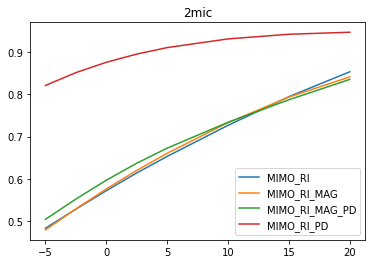

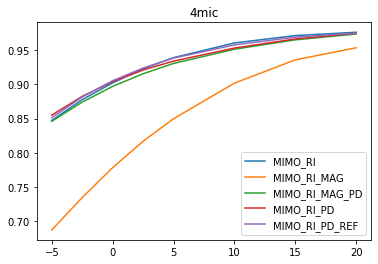

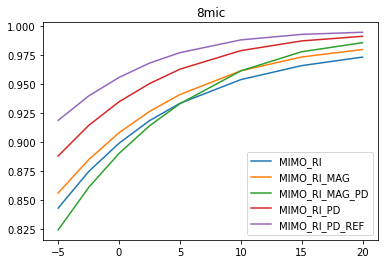

In [12]:
#plot (same loss function mic variation)
snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
measure = "frm_Acc"

keys_list = noisy_exp_dict.keys()
for num_mics in num_mics_list:
    plt.figure()  
    plt.title(f'{num_mics}mic') 
    Loss_cmp = Loss[:4] if num_mics==2 else Loss
    for loss in Loss_cmp:
        val_list=[]
        for _snr in snr_list:  
            app_str = f"snr_{_snr}"  
            key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}' #inside file pattern
            if key_str in keys_list:
                val = noisy_exp_dict[key_str]
            else:
                val = 0.0
            val_list.append(val)
        plt.plot(snr_list, val_list)
    plt.legend(Loss_cmp)
    

In [13]:
#plot (same loss function mic variation) #sanity check
sanity_check = False
if sanity_check:
    snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
    measure = "mic_fr"
    sub_mics_list = [2,4,0]
    keys_list = noisy_exp_dict.keys()
    for num_mics in [4,8]: 
        for loss in Loss:
            plt.figure()  
            plt.title(f'{loss}_{num_mics}mic') 
            for sub_mics in sub_mics_list:
                val_list=[]
                for _snr in snr_list:  
                    app_str = f"snr_{_snr}"  
                    if sub_mics==0:
                        key_str = f'{loss}_est_{num_mics}mic_enh_frm_Acc_{app_str}' #inside file pattern
                    else:
                        key_str = f'{loss}_est_{num_mics}mic_enh_{sub_mics}{measure}_{app_str}' #inside file pattern
                    if key_str in keys_list:
                        val = noisy_exp_dict[key_str]
                    else:
                        val = 0.0
                    val_list.append(val)
                plt.plot(snr_list, val_list)
            plt.legend(sub_mics_list)
    

In [21]:
noisy_reverb_ps_files = os.listdir(noisy_reverb_ps_log_dir)

noisy_reverb_ps_exp_dict={}
for _file in noisy_reverb_ps_files:
    file_path = os.path.join(noisy_reverb_ps_log_dir, _file)
    exp_dict = search_pattern_file(file_path, search_doa_pattern_list)
    noisy_reverb_ps_exp_dict.update(exp_dict)

In [15]:
#noisy_reverb_ps_exp_dict.keys()

dict_keys(['MIMO_RI_MAG_PD_est_2mic_enh_frm_Acc_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_2mic_enh_mae_ove_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_2mic_enh_utt_Acc_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_4mic_enh_2mic_fr_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_4mic_enh_frm_Acc_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_4mic_enh_mae_ove_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_4mic_enh_utt_Acc_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_8mic_enh_2mic_fr_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_8mic_enh_4mic_fr_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_8mic_enh_mae_ove_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_PD_est_8mic_enh_utt_Acc_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_est_2mic_enh_frm_Acc_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_est_2mic_enh_mae_ove_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_est_2mic_enh_utt_Acc_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_est_4mic_enh_2mic_fr_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_est_4mic_enh_frm_Acc_snr_-5.0_t60_0.4', 'MIMO_RI_MAG_est_4mic_enh_mae_ove_snr_-5.0_t60_0.4',

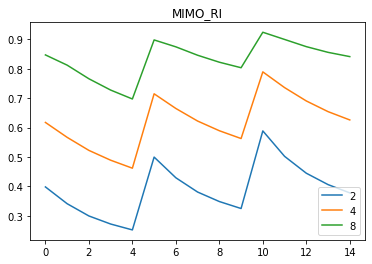

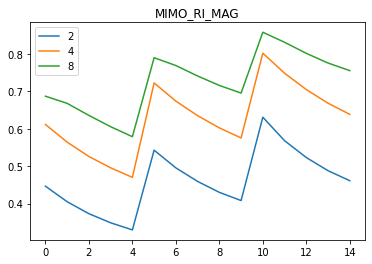

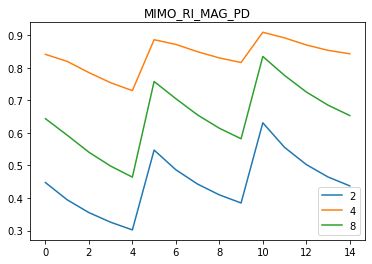

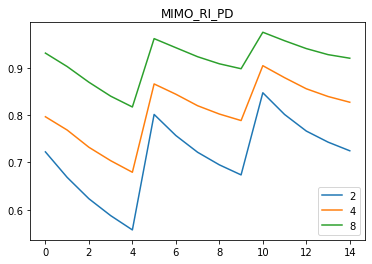

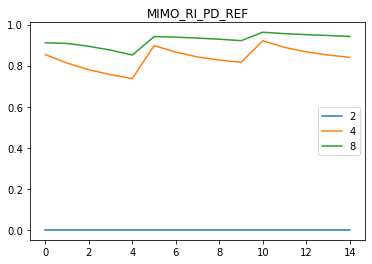

In [16]:
#plot (same loss function mic variation)
snr_list = [-5.0, 0.0, 5.0 ]
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
measure = "frm_Acc"

keys_list = noisy_reverb_ps_exp_dict.keys()
print(keys_list)
for loss in Loss:
    plt.figure()  
    plt.title(f'{loss}')    
    for num_mics in num_mics_list:
        val_list=[]
        for _snr in snr_list:  
            for _t60 in t60_list:
                app_str = f"snr_{_snr}_t60_{_t60}"  
                key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}' #inside file pattern       
                if key_str in keys_list:                  
                    val = noisy_reverb_ps_exp_dict[key_str]
                else:
                    val = 0.0
                val_list.append(val)
            
        plt.plot(val_list)
        plt.legend(num_mics_list)
    

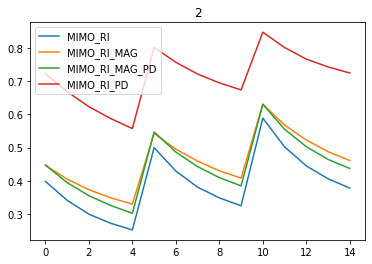

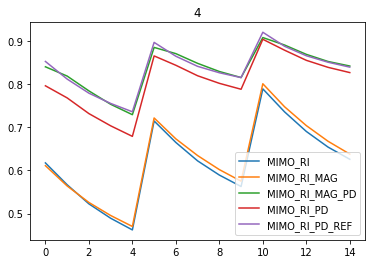

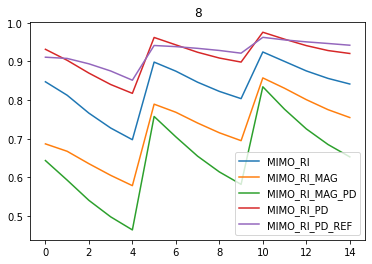

In [17]:
#plot (same loss function mic variation)
snr_list = [-5.0, 0.0, 5.0 ]
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
measure = "frm_Acc"

keys_list = noisy_reverb_ps_exp_dict.keys()
#print(keys_list)
for num_mics in num_mics_list:
    plt.figure()  
    plt.title(f'{num_mics}')
    Loss_cmp = Loss_cmp[:4] if num_mics==2 else Loss    
    for loss in Loss_cmp:
        val_list=[]
        for _snr in snr_list:  
            for _t60 in t60_list:
                app_str = f"snr_{_snr}_t60_{_t60}"  
                key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}' #inside file pattern       
                if key_str in keys_list:                  
                    val = noisy_reverb_ps_exp_dict[key_str]
                else:
                    val = 0.0
                val_list.append(val)
            
        plt.plot(val_list)
        plt.legend(Loss_cmp)
    

In [18]:
#same enhancement ,picking sub arrays
#plot (same loss function mic variation)
sanity_check = False
if sanity_check:
    snr_list = [-5.0, 0.0, 5.0]
    t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
    measure = "mic_fr"
    sub_mics_list = [2,4,0]
    keys_list = noisy_reverb_ps_exp_dict.keys()
    for num_mics in [4,8]: 
        for loss in Loss:
            plt.figure()  
            plt.title(f'{loss}_{num_mics}mic') 
            for sub_mics in sub_mics_list:
                val_list=[]
                for _snr in snr_list:  
                    for t60 in t60_list:
                        app_str = f"snr_{_snr}_t60_{t60}"  
                        if sub_mics==0:
                            key_str = f'{loss}_est_{num_mics}mic_enh_frm_Acc_{app_str}' #inside file pattern
                        else:
                            key_str = f'{loss}_est_{num_mics}mic_enh_{sub_mics}{measure}_{app_str}' #inside file pattern
                        
                        if key_str in keys_list:
                            val = noisy_reverb_ps_exp_dict[key_str]
                        else:
                            val = 0.0
                        val_list.append(val)
                plt.plot(val_list)
            plt.legend(sub_mics_list)
    
    

In [19]:
#noisy_reverb_ps_exp_dict['MIMO_RI_est_4mic_enh_2mic_fr_snr_-5.0_t60_0.2']

In [28]:
search_metrics_pattern_list = []
metrics_measures = ["STOI", "SNR", "PESQ_NB"]
for loss in Loss:
    for num_mics in num_mics_list:
        for measure in metrics_measures:
            if measure =="PESQ_NB" and (loss == "MIMO_RI_MAG_PD" or loss=="MIMO_RI_PD_REF"):
                doa_info_pattern = f'{measure}_{loss}_est_{num_mics}mic_enh' #inside file pattern
                search_metrics_pattern_list.append(doa_info_pattern)
            else:
                for mic_idx in range(num_mics):   
                    doa_info_pattern = f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}' #inside file pattern
                    search_metrics_pattern_list.append(doa_info_pattern)

In [21]:
#search_metrics_pattern_list

In [22]:
noisy_files = os.listdir(noisy_log_dir)

noisy_metrics_exp_dict={}
for _file in noisy_files:
    file_path = os.path.join(noisy_log_dir, _file)
    exp_dict = search_pattern_file(file_path, search_metrics_pattern_list)
    noisy_metrics_exp_dict.update(exp_dict)



In [23]:
#noisy_metrics_exp_dict

In [24]:
#plot (same loss function mic variation)
metrics_cmp = False
if metrics_cmp:
    snr_list = [-5.0] #, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
    measure = "PESQ_NB"

    keys_list = noisy_metrics_exp_dict.keys()
    for loss in Loss:
        plt.figure()  
        plt.title(f'{loss}') 
        
        for num_mics in [8]:
            val_list=[]
            for mic_idx in range(num_mics):        
                for _snr in snr_list:  
                    app_str = f"snr_{_snr}"  
                    key_str = f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}' #inside file pattern

                    if key_str in keys_list:
                        val = noisy_metrics_exp_dict[key_str]
                    else:
                        val = 0.0
                    val_list.append(val)
                plt.plot(val_list)
            
        plt.legend(Loss)
    

In [25]:
#plot (same loss function mic variation)
metrics_cmp = False
if metrics_cmp:
    snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
    measure = "STOI"

    keys_list = noisy_metrics_exp_dict.keys()

    for _snr in snr_list:     
        plt.figure()  
        plt.title(f'{_snr}')   
        for loss in Loss:
            for num_mics in [8]:
                val_list=[]     
                for mic_idx in range(num_mics):                 
                    app_str = f"snr_{_snr}"  
                    key_str = f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}' #inside file pattern

                    if key_str in keys_list:
                        val = noisy_metrics_exp_dict[key_str]
                    else:
                        val = 0.0
                    val_list.append(val)
                plt.plot(val_list)
            
        plt.legend(Loss)
    

In [26]:
noisy_reverb_ps_files = os.listdir(noisy_reverb_ps_log_dir)

noisy_reverb_ps_metrics_exp_dict={}
for _file in noisy_reverb_ps_files:
    file_path = os.path.join(noisy_reverb_ps_log_dir, _file)
    exp_dict = search_pattern_file(file_path, search_metrics_pattern_list)
    noisy_reverb_ps_metrics_exp_dict.update(exp_dict)


In [27]:
#plot (same loss function mic variation)
metrics_cmp=False
if metrics_cmp:
    snr_list = [-5.0, 0.0, 5.0]
    t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
    measure = "SNR"

    keys_list = noisy_reverb_ps_metrics_exp_dict.keys()

    for _snr in snr_list:   
        for t60 in t60_list:  
            plt.figure()  
            plt.title(f'{_snr}_{t60}')   
            for loss in Loss:
                for num_mics in [8]:
                    val_list=[]     
                    for mic_idx in range(num_mics):                 
                        app_str = f"snr_{_snr}_t60_{t60}"  
                        key_str = f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}' #inside file pattern

                        if key_str in keys_list:
                            val = noisy_reverb_ps_metrics_exp_dict[key_str]
                        else:
                            val = 0.0
                        val_list.append(val)
                    plt.plot(val_list)
            plt.legend(Loss)
    

In [31]:
reverb_files = os.listdir(reverb_log_dir)
reverb_upd_files = [x for x in reverb_files if os.path.isfile(os.path.join(reverb_log_dir, x))]

reverb_exp_dict={}
for _file in reverb_upd_files:
    file_path = os.path.join(reverb_log_dir, _file)
    exp_dict = search_pattern_file(file_path, search_doa_pattern_list)
    reverb_exp_dict.update(exp_dict)



In [29]:
#reverb_exp_dict

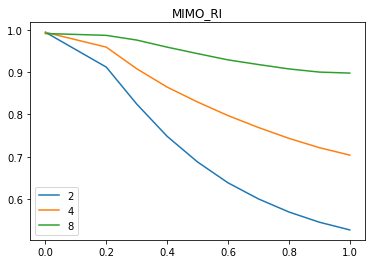

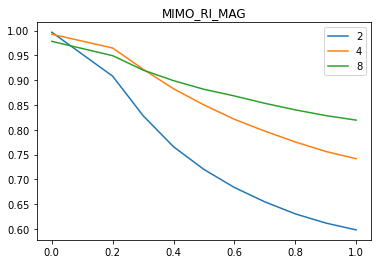

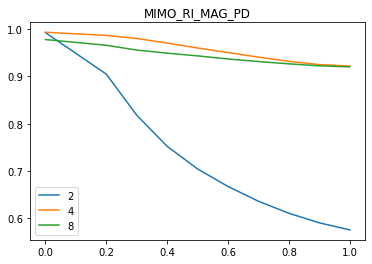

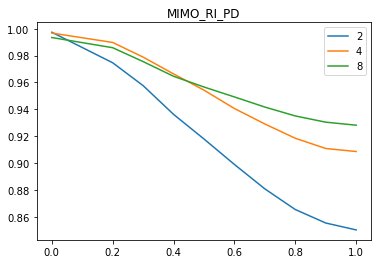

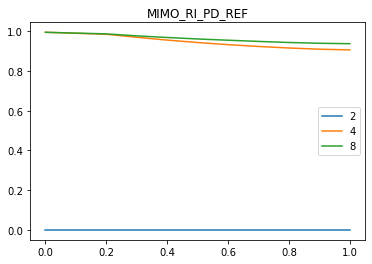

In [30]:
#plot (same loss function mic variation)
t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
measure = "frm_Acc"

keys_list = reverb_exp_dict.keys()
for loss in Loss:
    plt.figure()  
    plt.title(f'{loss}') 
    
    for num_mics in num_mics_list:
        val_list=[]
        for t60 in t60_list:  
            app_str = f"t60_{t60}"  
            key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}' #inside file pattern
            if key_str in keys_list:
                val = reverb_exp_dict[key_str]
            else:
                val = 0.0
            val_list.append(val)
        plt.plot(t60_list, val_list)
        
    plt.legend(num_mics_list)
    

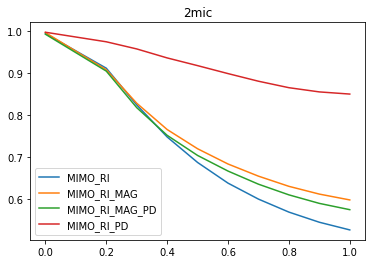

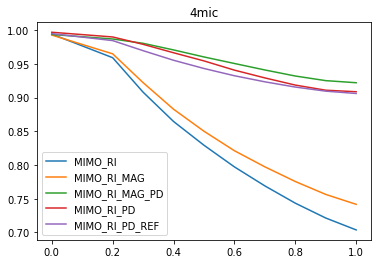

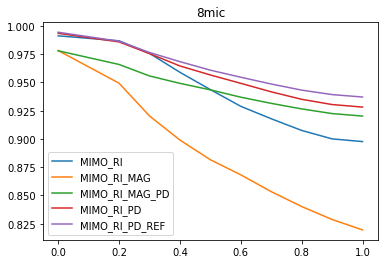

In [31]:
#plot (same loss function mic variation)
t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8, 0.9, 1.0]
measure = "frm_Acc"

keys_list = reverb_exp_dict.keys()
for num_mics in num_mics_list:
    plt.figure()  
    plt.title(f'{num_mics}mic') 
    Loss_cmp = Loss[:4] if num_mics==2 else Loss
    for loss in Loss_cmp:
        val_list=[]
        for t60 in t60_list:  
            app_str = f"t60_{t60}"  
            key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}' #inside file pattern
            if key_str in keys_list:
                val = reverb_exp_dict[key_str]
            else:
                val = 0.0
            val_list.append(val)
        plt.plot(t60_list, val_list)
    plt.legend(Loss_cmp)
    

Thoughts - Including PD term is useful

-  Mics Train        DR DN      DRN(PS) DRN (Diffuse) 
-     2   MAG_WT, SUM  PD PD PD                             Clear majority 
-     4   MAG_WT, SUM
-     8   IRM_WT, AVG  PD PD PD 


Consolidated numbers

In [32]:
measure = "frm_Acc"
t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8, 0.9, 1.0]
num_mics_list = [2,4,8]
print('Num Mics', Loss)
for num_mics in num_mics_list:
    Loss_cmp = Loss[:4] if num_mics==2 else Loss
    print(f"{num_mics}", end= ",")
    for loss in Loss_cmp:
        avg_acc = 0
        for t60 in t60_list:
            app_str = f't60_{t60}'      
            key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}'
            #print(key_str)
            avg_acc += reverb_exp_dict[key_str]
        avg_acc /= len(t60_list)

        #print(f"{loss} {num_mics} {avg_acc}")
        print(f'{avg_acc:.4f}', end= ",")
    print("\n")

Num Mics ['MIMO_RI', 'MIMO_RI_MAG', 'MIMO_RI_MAG_PD', 'MIMO_RI_PD', 'MIMO_RI_PD_REF']
2,0.7046,0.7399,0.7250,0.9135,

4,0.8290,0.8504,0.9562,0.9494,0.9434,

8,0.9409,0.8839,0.9430,0.9561,0.9610,



In [33]:
measure = "frm_Acc"
snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
num_mics_list = [2,4,8]
print('Num Mics' , Loss)
for num_mics in num_mics_list:
    Loss_cmp = Loss[:4] if num_mics==2 else Loss
    print(f"{num_mics}", end= "\t")
    for loss in Loss_cmp:
        avg_acc = 0
        avg_stoi = 0 
        for snr in snr_list:
            app_str = f'snr_{snr}'      
            key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}'
            
            #print(key_str)
            avg_acc += noisy_exp_dict[key_str]
            for mic_idx in range(num_mics):
                key_metric_str = f'STOI_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}'
                avg_stoi += noisy_metrics_exp_dict[key_metric_str]
        avg_acc /= len(snr_list)
        avg_stoi /= (num_mics*len(snr_list))


        #print(f"{loss} {num_mics} {avg_acc}")
        print(f'{avg_acc:.4f}', f'{avg_stoi:.4f}', end= "\t") #
    print("\n")

Num Mics ['MIMO_RI', 'MIMO_RI_MAG', 'MIMO_RI_MAG_PD', 'MIMO_RI_PD', 'MIMO_RI_PD_REF']
2	0.6529 0.9498	0.6538 0.9653	0.6647 0.9655	0.8967 0.9806	

4	0.9248 0.9764	0.8322 0.9683	0.9193 0.9791	0.9240 0.9755	0.9254 0.9778	

8	0.9203 0.9705	0.9290 0.9707	0.9186 0.9672	0.9511 0.9727	0.9670 0.9696	



In [34]:
#noisy_metrics_exp_dict

In [35]:
measure = "frm_Acc"
snr_list = [-5.0, 0.0, 5.0]
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
num_mics_list = [2,4,8]
print('Num Mics' , Loss)
for num_mics in num_mics_list:
    Loss_cmp = Loss[:4] if num_mics==2 else Loss
    print(f"{num_mics}", end= "\t")
    for loss in Loss_cmp:
        avg_acc = 0
        avg_stoi, avg_pesq = 0, 0
        for snr in snr_list:
            for t60 in t60_list:
                app_str = f'snr_{snr}_t60_{t60}'      
                key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}'
                #print(key_str)
                avg_acc += noisy_reverb_ps_exp_dict[key_str]
                for mic_idx in range(num_mics):
                    key_metric_str = f'STOI_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}'
                    key_pesq_str = f'PESQ_NB_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}'
                    avg_stoi += noisy_reverb_ps_metrics_exp_dict[key_metric_str]
                    avg_pesq += noisy_reverb_ps_metrics_exp_dict[key_pesq_str]
        avg_acc /= len(snr_list)*len(t60_list)
        avg_stoi /= num_mics*len(snr_list)*len(t60_list)
        avg_pesq /= num_mics*len(snr_list)*len(t60_list)

        #print(f"{loss} {num_mics} {avg_acc}")
        print(f'{avg_acc:.4f}', f'{avg_stoi:.4f}', f'{avg_pesq:.4f}', end= "\t") # 
    print("\n")

Num Mics ['MIMO_RI', 'MIMO_RI_MAG', 'MIMO_RI_MAG_PD', 'MIMO_RI_PD', 'MIMO_RI_PD_REF']
2	0.3911 0.7911 1.7979	0.4606 0.8008 2.1969	0.4457 0.8023 2.1625	0.7127 0.7874 1.8709	

4	0.6207 0.8103 1.9063	0.6289 0.8167 2.2601	0.8364 0.8287 2.2915	0.8073 0.7977 1.8059	0.8368 0.8146 1.9744	

8	0.8329 0.8263 1.9824	0.7267 0.8299 2.3139	0.6484 0.8264 2.1753	0.9146 0.8213 1.9591	0.9239 0.7193 1.4966	



In [36]:
#noisy_reverb_ps_exp_dict.keys()

In [29]:
noisy_reverb_diffuse_files = os.listdir(noisy_reverb_diffuse_log_dir)

noisy_reverb_diffuse_exp_dict={}
noisy_reverb_diffuse_metrics_exp_dict= {}
for _file in noisy_reverb_diffuse_files:
    file_path = os.path.join(noisy_reverb_diffuse_log_dir, _file)
    exp_dict = search_pattern_file(file_path, search_doa_pattern_list)
    noisy_reverb_diffuse_exp_dict.update(exp_dict)
    exp_dict_metrics = search_pattern_file(file_path, search_metrics_pattern_list)
    noisy_reverb_diffuse_metrics_exp_dict.update(exp_dict_metrics)

In [38]:
measure = "frm_Acc"
snr_list = [-5.0, 0.0, 5.0]
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
num_mics_list = [2,4,8]
print('Num Mics' , Loss)
for num_mics in num_mics_list:
    Loss_cmp = Loss[:4] if num_mics==2 else Loss
    print(f"{num_mics}", end= "\t")
    for loss in Loss_cmp:
        avg_acc = 0
        avg_stoi, avg_pesq= 0, 0
        tmp_count = 0
        for snr in snr_list:
            for t60 in t60_list:
                app_str = f'snr_{snr}_t60_{t60}'      
                key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}'
                #print(key_str)
                if key_str in noisy_reverb_diffuse_exp_dict:
                    avg_acc += noisy_reverb_diffuse_exp_dict[key_str]
                    for mic_idx in range(num_mics):
                        key_metric_str = f'STOI_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}'
                        key_pesq_str = f'PESQ_NB_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}'
                        avg_stoi += noisy_reverb_diffuse_metrics_exp_dict[key_metric_str]
                        avg_pesq += noisy_reverb_diffuse_metrics_exp_dict[key_pesq_str]
                    tmp_count += 1
        avg_acc /= tmp_count #len(snr_list)*len(t60_list)
        avg_stoi /= num_mics*tmp_count #len(snr_list)*len(t60_list)
        avg_pesq /= num_mics*tmp_count

        #print(f"{loss} {num_mics} {avg_acc}")
        print(f'{avg_acc:.4f}', f'{avg_stoi:.4f}', f'{avg_pesq:.4f}', end= "\t") #  
    print("\n")

Num Mics ['MIMO_RI', 'MIMO_RI_MAG', 'MIMO_RI_MAG_PD', 'MIMO_RI_PD', 'MIMO_RI_PD_REF']
2	0.3575 0.7832 1.8018	0.4414 0.7987 2.1775	0.3702 0.8006 2.0871	0.6370 0.7744 1.7351	

4	0.5783 0.8087 1.8546	0.6120 0.8119 2.2278	0.8283 0.8232 2.1775	0.7761 0.7775 1.6473	0.7938 0.7977 1.8215	

8	0.7975 0.8190 1.9303	0.8426 0.8286 2.2759	0.7623 0.8248 2.1441	0.9143 0.8173 1.8880	0.9138 0.7561 1.7340	



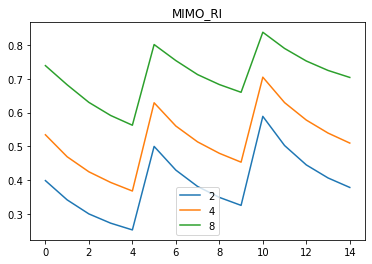

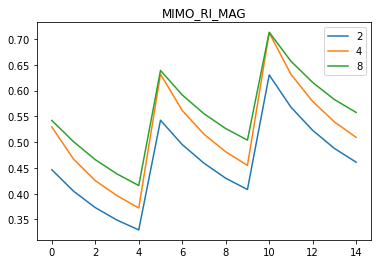

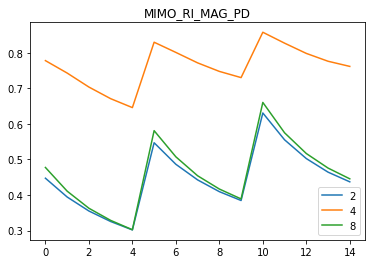

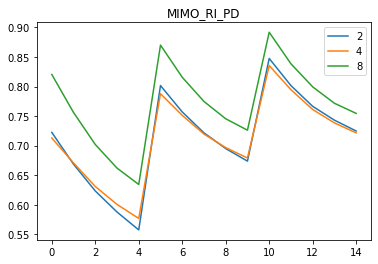

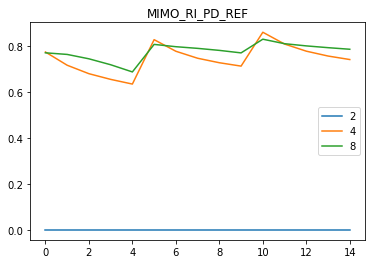

In [49]:
# sanity check comparing 2 mics of every enhancement
sanity_check = True
if sanity_check:
    snr_list = [-5.0, 0.0, 5.0]
    t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
    measure = "mic_fr"
    sub_mics_list = [2] #,4,0]
    keys_list = noisy_reverb_ps_exp_dict.keys()
    for loss in Loss:
        plt.figure()  
        plt.title(f'{loss}') 
        for num_mics in [2,4,8]:     

            for sub_mics in sub_mics_list:
                val_list=[]
                for _snr in snr_list:  
                    for t60 in t60_list:
                        app_str = f"snr_{_snr}_t60_{t60}"  
                        if sub_mics==0 or num_mics==2:
                            key_str = f'{loss}_est_{num_mics}mic_enh_frm_Acc_{app_str}' #inside file pattern
                        else:
                            key_str = f'{loss}_est_{num_mics}mic_enh_{sub_mics}{measure}_{app_str}' #inside file pattern
                        
                        if key_str in keys_list:
                            val = noisy_reverb_ps_exp_dict[key_str]
                        else:
                            val = 0.0
                        val_list.append(val)
                plt.plot(val_list)
            plt.legend([2,4,8])
    

In [23]:
#plotting frm Acc
from itertools import product

noisy_snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]

noisy_reverb_snr_list = [-5.0, 0.0, 5.0] #, 10.0, 20.0 ]
noisy_reverb_t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
noisy_reverb_list = list(product(noisy_reverb_snr_list, noisy_reverb_t60_list))

reverb_t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [8]:
def build_app_str(dataset_condition, val):
    if dataset_condition=="noisy":
        app_str = f'snr_{val}'
    elif dataset_condition=="noisy_reverb":
        app_str = f'snr_{val[0]}_t60_{val[1]}'   
    elif dataset_condition=="reverb":
        app_str = f't60_{val}'
    return app_str

In [15]:
def _print(measure, num_mics, exp_dict, dataset_condition, tst_conditions, loss_list, dataset_simulation=""):
    print(tst_conditions)
    for loss in loss_list:
        val_list = []
        for tst_val in tst_conditions:
            app_str = build_app_str(dataset_condition, tst_val)
            if "mix" in loss:
                key_str = f'{loss}_{num_mics}mic_{measure}_{app_str}'
            else:
                key_str = f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}'

            val_list.append(exp_dict[key_str])
        print(loss, val_list)


In [36]:
num_mics = 2
Loss = Loss = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD"] 
_print("frm_Acc", num_mics, reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("frm_Acc_epoch", num_mics, reverb_exp_dict, "reverb", reverb_t60_list, ["mix"])

_print("frm_Acc", num_mics, noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("frm_Acc_epoch", num_mics, noisy_exp_dict, "noisy", noisy_snr_list, ["mix"])
_print("frm_Acc", num_mics, noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("frm_Acc_epoch", num_mics, noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, ["mix"], "ps")
_print("frm_Acc", num_mics, noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")
_print("frm_Acc_epoch", num_mics, noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, ["mix"], "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIMO_RI [0.9942593574523926, 0.9118258953094482, 0.8244651556015015, 0.7481377720832825, 0.6874431371688843, 0.6382399201393127, 0.6002240777015686, 0.569313645362854, 0.5451806783676147, 0.5269289016723633]
MIMO_RI_MAG [0.9966035485267639, 0.9081100225448608, 0.8284704089164734, 0.7658553719520569, 0.7200989723205566, 0.6837948560714722, 0.6548566818237305, 0.6306507587432861, 0.6121883988380432, 0.5982962250709534]
MIMO_RI_MAG_PD [0.992713212966919, 0.9048815965652466, 0.817950963973999, 0.7520439624786377, 0.704155445098877, 0.6669726371765137, 0.6357415318489075, 0.6103572249412537, 0.5900669097900391, 0.5750925540924072]
MIMO_RI_PD [0.9974082112312317, 0.9746888875961304, 0.9576748013496399, 0.9362872838973999, 0.917939305305481, 0.8989838361740112, 0.8808170557022095, 0.8654304146766663, 0.8554027676582336, 0.8502568006515503]
[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


KeyError: 'mix_2mic_frm_Acc_epoch_t60_0.0'